In [3]:
from io import open
import glob
import os
import unicodedata
import string

def findFiles(path): return glob.glob(path)
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print(f"n_letters:{n_letters}")
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn' and c in all_letters )

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(f"n_categories:{n_categories}")
print(f"len of category_lines:{len(category_lines)}")
print(f"len of all_categories:{len(all_categories)}")
print(category_lines['Italian'][:5])
print(unicodeToAscii("O'Néàl"))

n_letters:57
n_categories:18
len of category_lines:18
len of all_categories:18
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
O'Neal


# Creating the Network

In [91]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):   # [1, 18]，[1, 57]，[1,128]
        input_combined = torch.cat((category, input, hidden), 1)  # [1, 203]
        hidden = self.i2h(input_combined)  # [1, 128]
        output = self.i2o(input_combined) # [1, 57]
        output_combined = torch.cat((hidden, output), 1) # [1, 185]  
        output = self.o2o(output_combined)  # [1, 57]
        output = self.dropout(output)  # [1, 57]
        output = self.softmax(output)  # [1, 57] 
        return output, hidden  # [1, 57]  [1, 128]
        
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# Preparing for Training

In [93]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTraningPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)  # [S, 1, D]
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1)  # EOS
    return torch.LongTensor(letter_indexes)

def randomTraningExample():
    category, line = randomTraningPair()
    category_tensor = categoryTensor(category)  # [1, 18]
    input_line_tensor = inputTensor(line)  # [S, 1, 57]
    target_line_tensor = targetTensor(line)  # [S]
    return category_tensor, input_line_tensor, target_line_tensor
    

# Training the Network

In [24]:
criterion = nn.NLLLoss()
learning_rate = 0.0005
def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    rnn.zero_grad()
    loss = torch.Tensor([0])
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])
    loss.backward()
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss.item() / input_line_tensor.size(0)
    
import time, math
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

rnn = RNN(n_letters, 128, n_letters)
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0
start = time.time()
for iter in range(1, n_iters+1):
    output, loss = train(*randomTraningExample())
    total_loss += loss
    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 9s (5000 5%) 2.7521
0m 18s (10000 10%) 2.9174
0m 27s (15000 15%) 3.1113
0m 36s (20000 20%) 2.8135
0m 45s (25000 25%) 2.5806
0m 55s (30000 30%) 2.8577
1m 4s (35000 35%) 2.9429
1m 13s (40000 40%) 2.2619
1m 22s (45000 45%) 2.9781
1m 32s (50000 50%) 2.5362
1m 41s (55000 55%) 3.0740
1m 50s (60000 60%) 2.0296
1m 59s (65000 65%) 2.7937
2m 8s (70000 70%) 2.5811
2m 18s (75000 75%) 2.1601
2m 27s (80000 80%) 2.8350
2m 36s (85000 85%) 3.1849
2m 45s (90000 90%) 1.8386
2m 54s (95000 95%) 1.9388
3m 4s (100000 100%) 1.8875


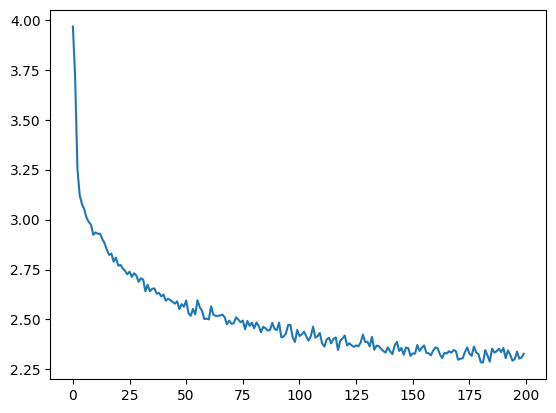

In [27]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(all_losses)

# Sampling the Network

In [33]:
max_length = 20
def sample(category, start_letter='A'):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()
        output_name = start_letter
        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)
        return output_name

def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')
samples('Chinese', 'CHI')

Ramanov
Uakilov
Sakovaki
Cha
Han
Ian
